# Python Machine Learning - Classifying handwritten digits

## Data Description

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

•Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, and 60,000 samples)

•Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, and 60,000 labels)

•Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, unzipped and 10,000 samples)

•Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, and 10,000 labels)

The MNIST dataset was constructed from two datasets of the US National Institute of Standards and Technology (NIST). The training set consists of handwritten digits from 250 different people, 50 percent high school students, and 50 percent employees from the Census Bureau. Note that the test set contains handwritten digits from different people following the same split.

## Obtaining the MNIST dataset 

In [1]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
mnist = read_data_sets("MNIST/", one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [26]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [27]:
X_train, y_train = load_mnist('MNIST/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [28]:
X_test, y_test = load_mnist('MNIST/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


## Visualize the digit 

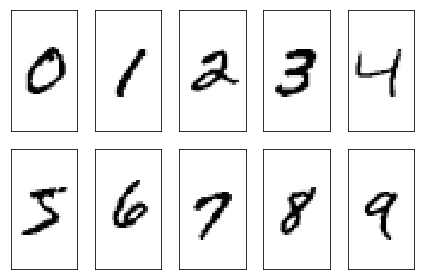

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

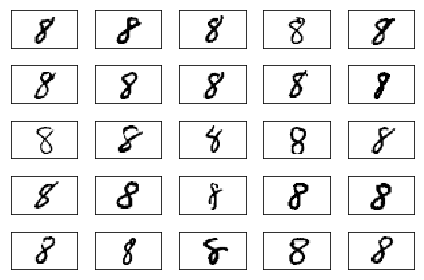

In [30]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 8][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [2]:
import tensorflow as tf
sess = tf.InteractiveSession()

# Softmax regression

Create placeholder

In [3]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

Define weights & bias

In [4]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.global_variables_initializer())

Lost function

In [5]:
y = tf.nn.softmax(tf.matmul(x,W) + b)

In [6]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

Training model

In [7]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

In [8]:
for i in range(1000):
  batch = mnist.train.next_batch(50)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

Model evaluation

In [9]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [10]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [11]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9134


# Multilayer Convolutional Networks

Weight Initialization

In [12]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Convolution and Pooling

In [13]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

First layer  

In [14]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [15]:
x_image = tf.reshape(x, [-1,28,28,1])

In [16]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

Second layer

In [17]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Fully connected layer

In [18]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Apply Dropout to reduce the overfitting

In [19]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Output layer

In [20]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

Training and evaluation of the model

In [21]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())

for i in range(10000):
  batch = mnist.train.next_batch(50)
  if i%500 == 0:
    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.04
step 500, training accuracy 0.92
step 1000, training accuracy 0.98
step 1500, training accuracy 0.96
step 2000, training accuracy 0.96
step 2500, training accuracy 1
step 3000, training accuracy 1
step 3500, training accuracy 1
step 4000, training accuracy 0.98
step 4500, training accuracy 1
step 5000, training accuracy 1
step 5500, training accuracy 0.98
step 6000, training accuracy 1
step 6500, training accuracy 0.98
step 7000, training accuracy 1
step 7500, training accuracy 1
step 8000, training accuracy 1
step 8500, training accuracy 1
step 9000, training accuracy 1
step 9500, training accuracy 1
test accuracy 0.9903
